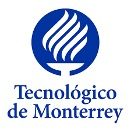

# AVANCE 1. ANÁLISIS EXPLORATORIO DE DATOS

**MATERIA:** Proyecto Integrador

**PROFESOR TITULAR:** Dra. Grettel Barceló / Dr. Luis Falcón

**EQUIPO:** 23

**ALUMNOS:**

*   Oswaldo Zárate Cisneros - A01204036
*   Elizabeth López Tapia - A01795851
*   Fernando Gutiérrez Vargas - A01795713


**INSTRUCCIONES:**

Este primer avance consiste en realizar un análisis exploratorio de datos (EDA - Exploratory Data Analysis), es decir, describir los datos utilizando técnicas estadísticas y de visualización (análisis univariante y bi/multivariante) para hacer enfoque en sus aspectos más relevantes, así como aplicar y justificar operaciones de preprocesamiento, relacionadas con el manejo de valores faltantes, atípicos y alta cardinalidad. Es importante que incluyan sus conclusiones del EDA, identificando tendencias o relaciones importantes.

Las siguientes son algunas de las preguntas comunes que podrán abordar a través del EDA:



1.   ¿Hay valores faltantes en el conjunto de datos?
2.   ¿Se pueden identificar patrones de ausencia?
3.   ¿Cuáles son las estadísticas resumidas del conjunto de datos?
4.   ¿Hay valores atípicos en el conjunto de datos?
5.   ¿Cuál es la cardinalidad de las variables categóricas?
6.   ¿Existen distribuciones sesgadas en el conjunto de datos?
7.   ¿Necesitamos aplicar alguna transformación no lineal?
8.   ¿Se identifican tendencias temporales? (En caso de que el conjunto incluya una dimensión de tiempo)
9.   ¿Hay correlación entre las variables dependientes e independientes?
10.   ¿Cómo se distribuyen los datos en función de diferentes categorías? (análisis bivariado)
11.  ¿Se deberían normalizar las imágenes para visualizarlas mejor?
12.  ¿Hay desequilibrio en las clases de la variable objetivo?

**1.   Carga de los datos**


In [ ]:
# @title
# Importación de Librerías
import io
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

In [ ]:
# Carga de datos desde Hugging Face
# Dataset CORD: Consolidated Receipt Dataset for post-OCR parsing
# Cargamos un subconjunto para optimizar espacio en disco (~500MB vs 4.3GB)

dataset = load_dataset("naver-clova-ix/cord-v2")

# Ver estructura del dataset
print("Dataset structure:")
print(dataset)
print(f"\nTrain samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

# Ver un ejemplo
print("\nExample keys:", dataset['train'][0].keys())

# Mostrar ejemplo de ground_truth (anotaciones)
import json
gt = json.loads(dataset['train'][0]['ground_truth'])
print("\nGround truth structure:")
print(json.dumps(gt, indent=2)[:500] + "...")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-b4aaeceff1d90e(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00004-7dbbe248962764(…):   0%|          | 0.00/441M [00:00<?, ?B/s]

data/train-00002-of-00004-688fe1305a55e5(…):   0%|          | 0.00/444M [00:00<?, ?B/s]

data/train-00003-of-00004-2d0cd200555ed7(…):   0%|          | 0.00/456M [00:00<?, ?B/s]

data/validation-00000-of-00001-cc3c5779f(…):   0%|          | 0.00/242M [00:00<?, ?B/s]

data/test-00000-of-00001-9c204eb3f4e1179(…):   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

Train samples: 800
Validation samples: 100
Test samples: 100

Example keys: dict_keys(['image', 'ground_truth'])

Ground truth structure:
{
  "gt_parse": {
    "menu": [
      {
        "nm": "Nasi Campur Bali",
        "cnt": "1 x",
        "price": "75,000"
      },
      {
        "nm": "Bbk Bengil Nasi",
        "cnt": "1 x",
        "price": "125,000"
      },
      {
        "nm": "MilkShake Starwb",
        "cnt": "1 x",
        "price": "37,000"
      },
      {
        "nm": "Ice Lemon Tea",
        "cnt": "1 x",
        "price": "24,000"
      },
      {
        "nm": "Nasi Ayam Dewata",
        "cnt": "1 x",
        "pr...


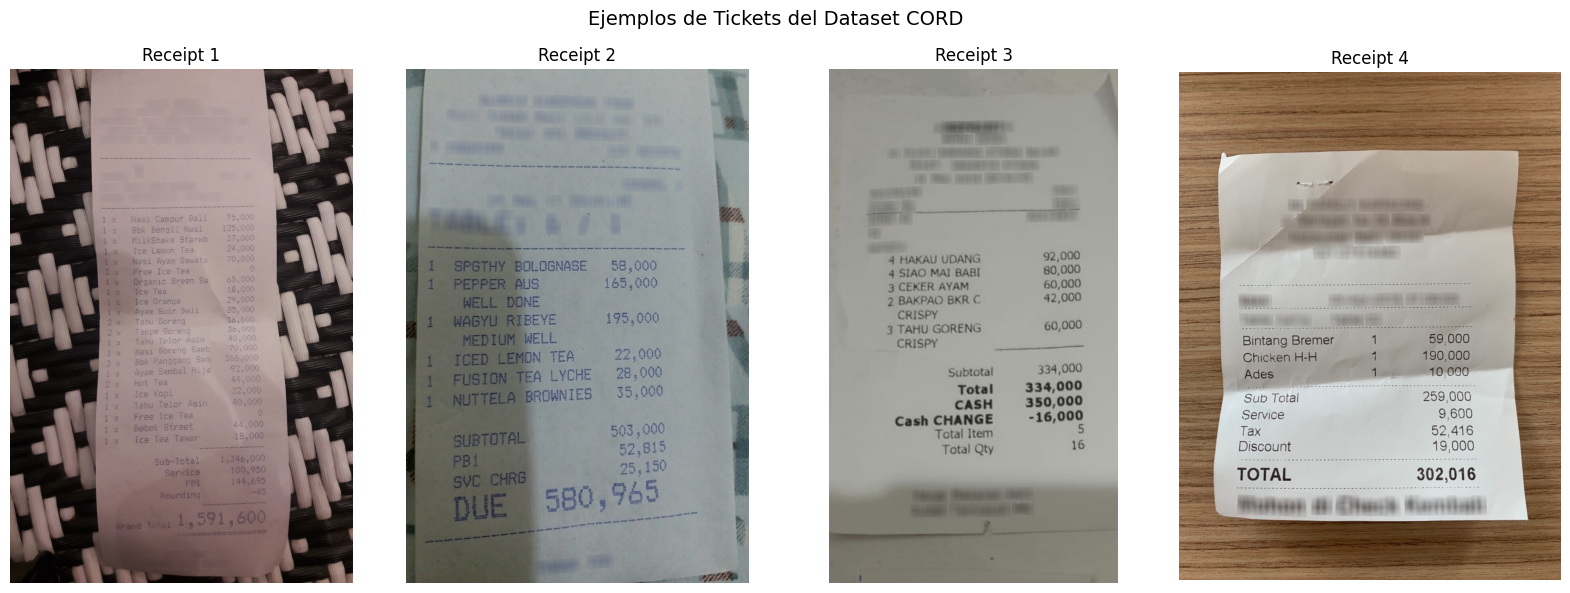

In [ ]:
# Visualizar algunas imágenes de ejemplo del dataset
fig, axes = plt.subplots(1, 4, figsize=(16, 6))

for i, ax in enumerate(axes):
    img = dataset['train'][i]['image']
    ax.imshow(img)
    ax.set_title(f'Receipt {i+1}')
    ax.axis('off')

plt.suptitle('Ejemplos de Tickets del Dataset CORD', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Análisis Univariante: Resolución y dimensiones, Formatos de imagen, Calidad Visual.
# Extraer metadatos y métricas de calidad de las imágenes del dataset

data_list = []

# Usar el split de entrenamiento para el análisis
for i, sample in enumerate(dataset['train']):
    img_pil = sample['image']

    # Convertir PIL Image a numpy array para OpenCV
    img_np = np.array(img_pil)

    if len(img_np.shape) == 3:  # Color image
        height, width, _ = img_np.shape
        # Convertir RGB a BGR para OpenCV, luego a gris
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    else:  # Grayscale
        height, width = img_np.shape
        gray = img_np

    # Calcular brillo promedio y contraste
    brightness = np.mean(gray)
    contrast = gray.std()

    # Estimar tamaño en KB (comprimido como JPEG)
    buffer = io.BytesIO()
    img_pil.save(buffer, format='JPEG', quality=85)
    size_kb = len(buffer.getvalue()) / 1024

    data_list.append({
        'width': width,
        'height': height,
        'aspect_ratio': width / height,
        'brightness': brightness,
        'contrast': contrast,
        'size_kb': size_kb
    })

df = pd.DataFrame(data_list)
print(f"Total de imágenes analizadas: {len(df)}")
df.head(10)

Total de imágenes analizadas: 800


,width,height,aspect_ratio,brightness,contrast,size_kb
0,864,1296,0.666667,109.002538,57.135133,164.782227
1,864,1296,0.666667,133.932044,29.482342,133.590820
2,720,1280,0.562500,149.976749,21.794545,58.679688
3,1108,1478,0.749662,147.646526,46.680661,251.319336
4,864,1296,0.666667,200.910413,19.657930,100.458008
5,2304,4096,0.562500,159.878591,59.760149,578.203125
6,864,1296,0.666667,164.308582,59.105091,120.175781
7,864,1296,0.666667,113.159536,90.521855,122.031250
8,864,1296,0.666667,129.927198,30.091420,123.570312
9,864,1296,0.666667,183.642768,38.607061,176.653320


* Con base en el Dataframe resultante, podemos observar que hay tickets con dimensiones muy grandes, uno de ellos el "receipt_00129.png", esto indica una alta variabilidad en la resolución.

* Todas la imagenes se encuentran en formato PNG por lo que no hay mezcla de formatos.

* Para la calidad de brillo, se indentifica una alta variabilidad, esto ocasionado por los diferentes tipos de celulares y condiciones climáticas donde se obtuvieron las imágenes.

**2.   Análisis Exploratorio de Datos (EDA)**

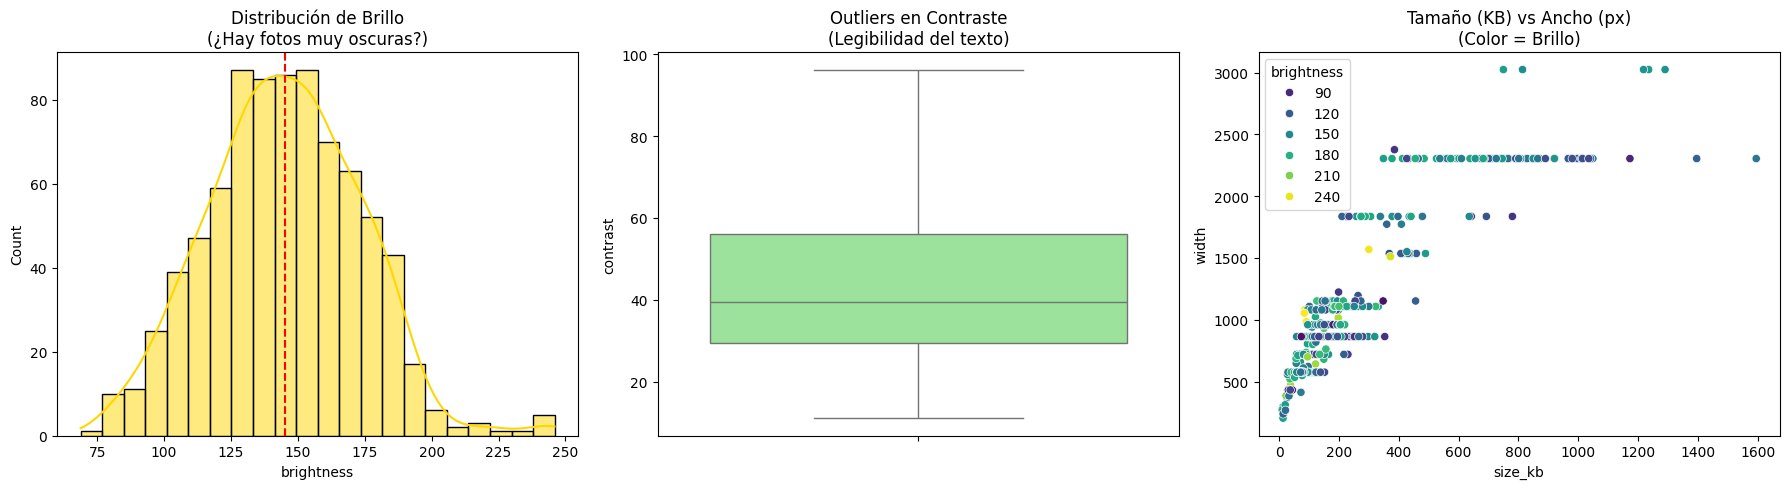


--- Estadísticas Descriptivas ---
       brightness    contrast      size_kb
count  800.000000  800.000000   800.000000
mean   145.076710   43.844490   198.194032
std     28.349541   18.706150   223.882921
min     68.804036   11.083755    10.534180
25%    126.012876   29.390275    76.672607
50%    144.516925   39.519355   121.242676
75%    165.000400   56.161277   194.812012
max    245.932837   96.257010  1595.273438


In [ ]:
#Visualización de Distribuciones y Outliers:

# Crear una figura con 3 subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Histograma de Brillo (Distribución y Sesgo)
sns.histplot(df['brightness'], kde=True, ax=axes[0], color='gold')
axes[0].set_title('Distribución de Brillo\n(¿Hay fotos muy oscuras?)')
axes[0].axvline(df['brightness'].mean(), color='red', linestyle='--', label='Media')

# 2. Boxplot de Contraste (Detección de Outliers)
sns.boxplot(y=df['contrast'], ax=axes[1], color='lightgreen')
axes[1].set_title('Outliers en Contraste\n(Legibilidad del texto)')

# 3. Dispersión: Tamaño vs Resolución (Relación entre variables)
sns.scatterplot(data=df, x='size_kb', y='width', hue='brightness', palette='viridis', ax=axes[2])
axes[2].set_title('Tamaño (KB) vs Ancho (px)\n(Color = Brillo)')

plt.tight_layout()
plt.show()

# Resumen de estadísticas para tu reporte
print("\n--- Estadísticas Descriptivas ---")
print(df[['brightness', 'contrast', 'size_kb']].describe())


**1.- Distribución de Brillo:**
* La distribución es casi normal, centrada en una media de 145.07. Sin embargo, tiene una "cola" hacia la derecha (valores cercanos a 245) y algunos valores muy bajos (68.8).

* Existen imágenes con sobreexposición (muy blancas) y subexposición (muy oscuras).

* Acción de Preprocesamiento: Se justifica el uso de CLAHE (Contrast Limited Adaptive Histogram Equalization) para normalizar el brillo localmente y mejorar la lectura de texto en zonas con sombras.


**2.- Outlier en Contraste:**
* El contraste promedio es de 43.84. Lo más importante es que el "bigote" superior llega casi a 100, pero tiene valores mínimos de 11.08.

* Los tickets con contraste cercano a 11 son "imágenes lavadas" donde el texto apenas se distingue del fondo.

* Acción de Preprocesamiento: Aplicar una Binarización de Otsu o un umbral adaptativo para separar forzosamente el texto del fondo, ignorando las variaciones de contraste.

**3.- Tamaño vs Resolución:**
* Se tiene un grupo masivo de imágenes por debajo de los 4,000 KB, pero hay puntos aislados que llegan casi a los 14,000 KB (13.9 MB). También se ven "escalones" en el ancho (width), lo que indica que las fotos vienen de diferentes dispositivos o configuraciones de WhatsApp.

* La alta dispersión en el peso de los archivos ($std = 2508 KB$) confirma una alta variabilidad en la calidad de captura.

* Para evaluación de modelos OCR, mantendremos el tamaño original para preservar la calidad del texto y evitar artefactos de escalado.

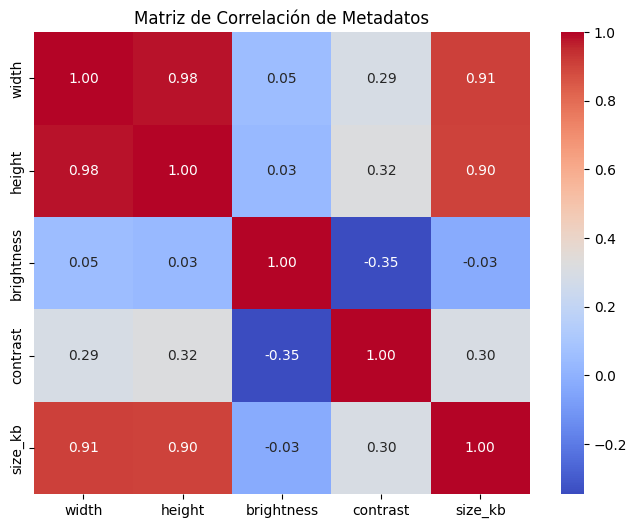

In [ ]:
#Matriz de Correlación:

plt.figure(figsize=(8, 6))
correlation_matrix = df[['width', 'height', 'brightness', 'contrast', 'size_kb']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Metadatos')
plt.show()


La matriz revela relaciones críticas entre las dimensiones de las imágenes y su calidad:

* Correlación Extrema ($0.93$ a $0.98$): Existe una relación casi lineal entre width, height y size_kb. Esto es lógico: a mayor resolución, mayor peso del archivo.

* Brillo vs. Contraste ($-0.35$): Hay una correlación negativa moderada. Esto sugiere que, a medida que el ticket es más brillante (más blanco), el contraste tiende a disminuir.

* Independencia del Brillo ($0.03$ a $0.05$): El brillo no depende de la resolución. Esto confirma que el problema de la iluminación es externo (cómo se tomó la foto) y no técnico (el sensor o la app).

**2.1 Análisis de Texto (Word Statistics)**

Para evaluar modelos de extracción de texto (OCR), es fundamental entender las características del texto en las imágenes: cantidad de palabras, longitud de palabras, y distribución de caracteres.

In [ ]:
# Extracción de estadísticas de texto desde ground_truth
import json

word_stats = []

for i, sample in enumerate(dataset['train']):
    gt = json.loads(sample['ground_truth'])

    # Extraer todas las palabras de valid_line
    words = []
    if 'valid_line' in gt:
        for line in gt['valid_line']:
            if 'words' in line:
                for word in line['words']:
                    if 'text' in word:
                        words.append(word['text'])

    # Calcular estadísticas por imagen
    num_words = len(words)
    word_lengths = [len(w) for w in words]
    total_chars = sum(word_lengths)
    avg_word_length = np.mean(word_lengths) if word_lengths else 0

    # Contar tipos de caracteres
    all_text = ''.join(words)
    num_digits = sum(c.isdigit() for c in all_text)
    num_alpha = sum(c.isalpha() for c in all_text)
    num_special = len(all_text) - num_digits - num_alpha

    word_stats.append({
        'num_words': num_words,
        'total_chars': total_chars,
        'avg_word_length': avg_word_length,
        'num_digits': num_digits,
        'num_alpha': num_alpha,
        'num_special': num_special,
        'digit_ratio': num_digits / total_chars if total_chars > 0 else 0
    })

df_words = pd.DataFrame(word_stats)
print(f"Estadísticas de texto extraídas de {len(df_words)} imágenes")
df_words.head(10)

Estadísticas de texto extraídas de 800 imágenes


,num_words,total_chars,avg_word_length,num_digits,num_alpha,num_special,digit_ratio
0,135,493,3.651852,155,309,29,0.314402
1,39,185,4.743590,61,114,10,0.329730
2,39,172,4.410256,56,106,10,0.325581
3,22,111,5.045455,45,57,9,0.405405
4,18,86,4.777778,38,39,9,0.441860
5,35,186,5.314286,65,110,11,0.349462
6,23,103,4.478261,48,45,10,0.466019
7,15,81,5.400000,34,39,8,0.419753
8,17,88,5.176471,35,41,12,0.397727
9,14,80,5.714286,32,40,8,0.400000


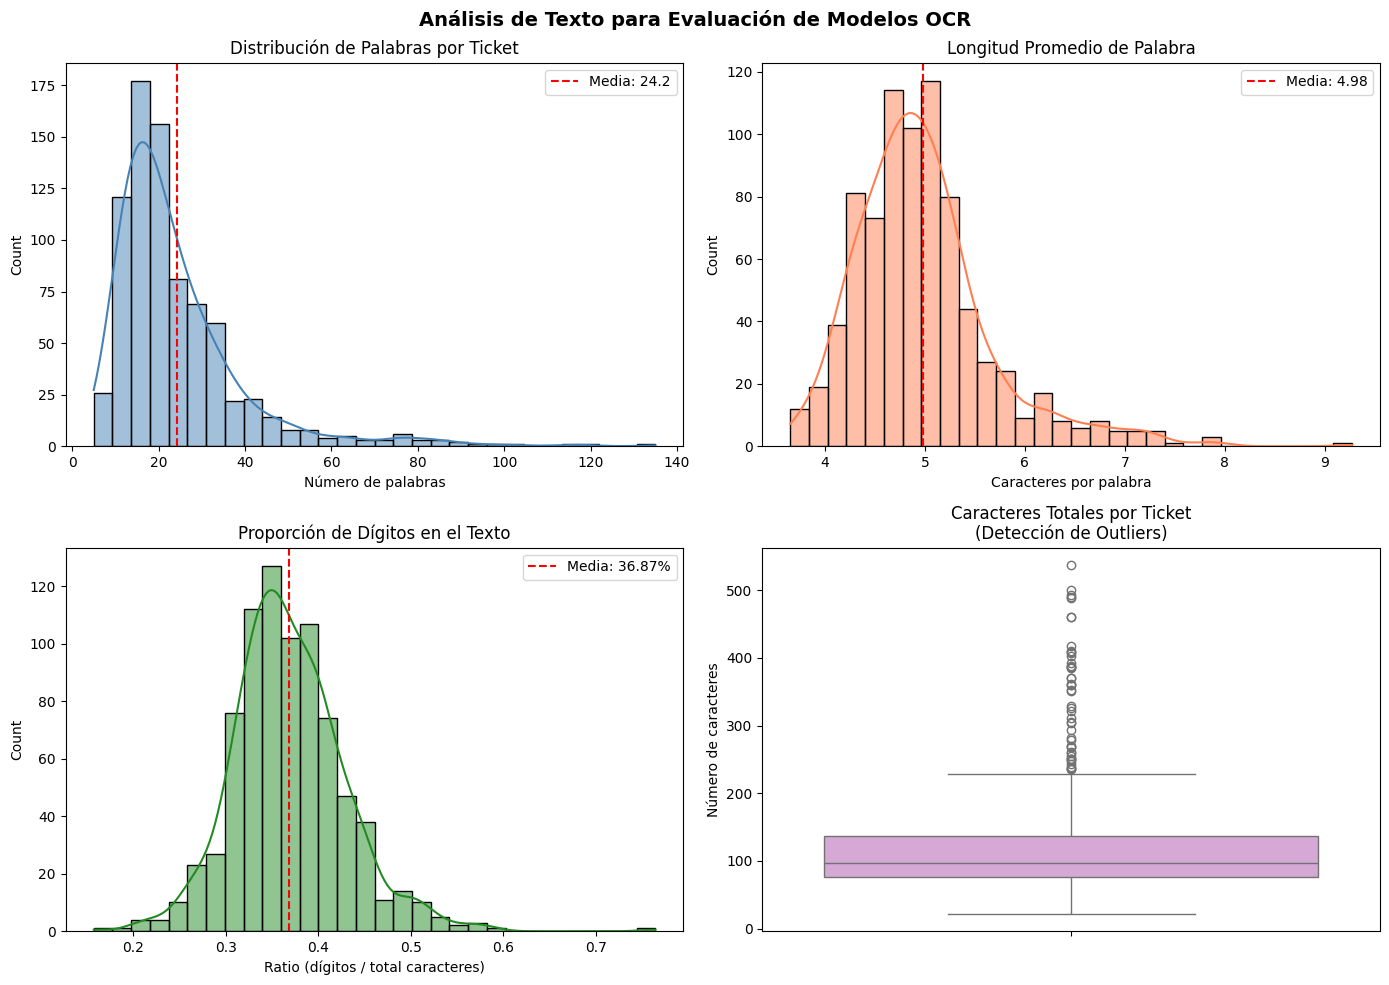


--- Estadísticas de Texto ---
        num_words  total_chars  avg_word_length  digit_ratio
count  800.000000   800.000000       800.000000   800.000000
mean    24.208750   118.191250         4.975583     0.368706
std     15.651402    73.004155         0.692614     0.060786
min      5.000000    22.000000         3.651852     0.157205
25%     15.000000    76.000000         4.538462     0.330292
50%     20.000000    97.000000         4.880570     0.361702
75%     28.000000   137.250000         5.267073     0.403226
max    135.000000   537.000000         9.272727     0.764706


In [ ]:
# Visualización de estadísticas de texto
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribución de palabras por imagen
sns.histplot(df_words['num_words'], kde=True, ax=axes[0, 0], color='steelblue', bins=30)
axes[0, 0].set_title('Distribución de Palabras por Ticket')
axes[0, 0].set_xlabel('Número de palabras')
axes[0, 0].axvline(df_words['num_words'].mean(), color='red', linestyle='--', label=f"Media: {df_words['num_words'].mean():.1f}")
axes[0, 0].legend()

# 2. Distribución de longitud promedio de palabra
sns.histplot(df_words['avg_word_length'], kde=True, ax=axes[0, 1], color='coral', bins=30)
axes[0, 1].set_title('Longitud Promedio de Palabra')
axes[0, 1].set_xlabel('Caracteres por palabra')
axes[0, 1].axvline(df_words['avg_word_length'].mean(), color='red', linestyle='--', label=f"Media: {df_words['avg_word_length'].mean():.2f}")
axes[0, 1].legend()

# 3. Proporción de dígitos vs letras
sns.histplot(df_words['digit_ratio'], kde=True, ax=axes[1, 0], color='forestgreen', bins=30)
axes[1, 0].set_title('Proporción de Dígitos en el Texto')
axes[1, 0].set_xlabel('Ratio (dígitos / total caracteres)')
axes[1, 0].axvline(df_words['digit_ratio'].mean(), color='red', linestyle='--', label=f"Media: {df_words['digit_ratio'].mean():.2%}")
axes[1, 0].legend()

# 4. Boxplot de caracteres totales
sns.boxplot(y=df_words['total_chars'], ax=axes[1, 1], color='plum')
axes[1, 1].set_title('Caracteres Totales por Ticket\n(Detección de Outliers)')
axes[1, 1].set_ylabel('Número de caracteres')

plt.suptitle('Análisis de Texto para Evaluación de Modelos OCR', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Estadísticas resumidas
print("\n--- Estadísticas de Texto ---")
print(df_words[['num_words', 'total_chars', 'avg_word_length', 'digit_ratio']].describe())

**Interpretación de Estadísticas de Texto:**

1. **Palabras por Ticket:** El promedio es de **24.2 palabras** por ticket (std=15.7), con un rango de 5 a 135 palabras. Esto indica una alta variabilidad en la complejidad del texto. Los tickets con más de 100 palabras representan casos extremos que pueden requerir más tiempo de procesamiento.

2. **Longitud Promedio de Palabra:** La media es de **4.98 caracteres** por palabra (rango: 3.65 - 9.27). Esta longitud relativamente corta confirma el uso frecuente de abreviaturas y códigos en los tickets, típico del formato de recibos.

3. **Proporción de Dígitos:** En promedio, **36.9%** del texto son dígitos (std=6.1%), con un rango de 15.7% a 76.5%. Esta alta proporción es crítica para nuestro objetivo de extraer folios/números - el modelo OCR debe ser especialmente preciso reconociendo dígitos.

4. **Caracteres Totales:** El promedio es **118 caracteres** por ticket (std=73), con outliers que llegan hasta 537 caracteres. El dataset contiene **94,553 caracteres totales**, de los cuales:
   - **36.0%** son dígitos (34,038)
   - **54.8%** son letras (51,817)
   - **9.2%** son caracteres especiales (8,698)
   
5. **Vocabulario:** El dataset contiene **19,367 palabras** en total, con un vocabulario único de **4,696 palabras**. La longitud de palabras individuales varía de 1 a 25 caracteres, con una media de 4.88.

Total de palabras en el dataset: 19,367
Vocabulario único: 4,696 palabras


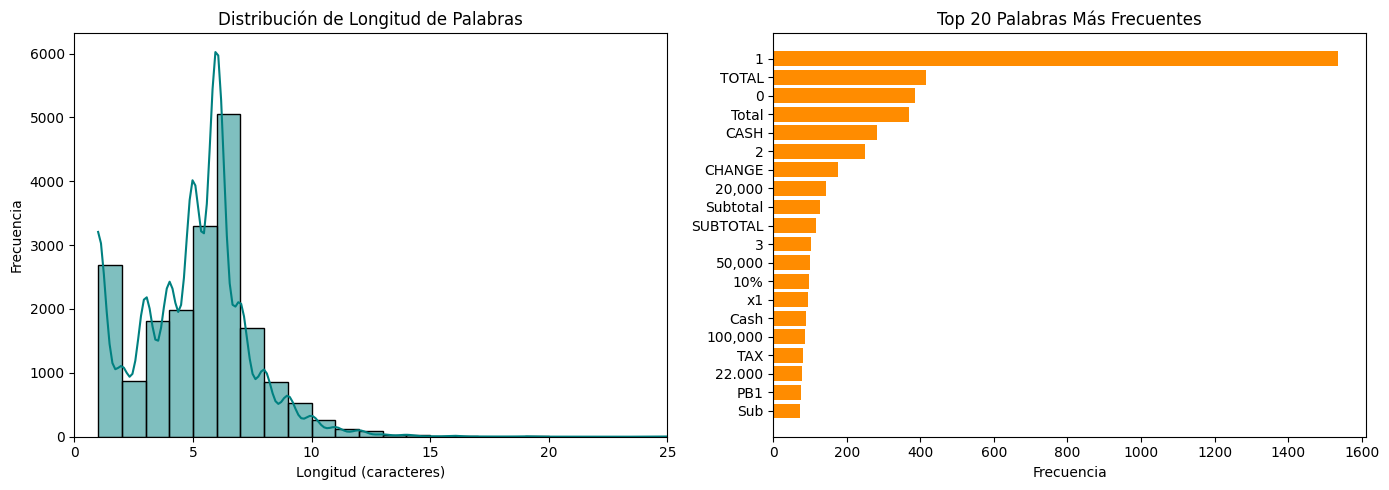


Longitud de palabras - Min: 1, Max: 25, Media: 4.88


In [ ]:
# Análisis detallado: Distribución de longitud de palabras individuales
all_words = []
all_word_lengths = []

for sample in dataset['train']:
    gt = json.loads(sample['ground_truth'])
    if 'valid_line' in gt:
        for line in gt['valid_line']:
            if 'words' in line:
                for word in line['words']:
                    if 'text' in word:
                        all_words.append(word['text'])
                        all_word_lengths.append(len(word['text']))

print(f"Total de palabras en el dataset: {len(all_words):,}")
print(f"Vocabulario único: {len(set(all_words)):,} palabras")

# Visualización de longitud de palabras
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de longitud de palabras
sns.histplot(all_word_lengths, kde=True, ax=axes[0], color='teal', bins=range(1, max(all_word_lengths)+2))
axes[0].set_title('Distribución de Longitud de Palabras')
axes[0].set_xlabel('Longitud (caracteres)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xlim(0, 25)

# Top 20 palabras más frecuentes
from collections import Counter
word_counts = Counter(all_words)
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

axes[1].barh(range(len(words)), counts, color='darkorange')
axes[1].set_yticks(range(len(words)))
axes[1].set_yticklabels(words)
axes[1].invert_yaxis()
axes[1].set_title('Top 20 Palabras Más Frecuentes')
axes[1].set_xlabel('Frecuencia')

plt.tight_layout()
plt.show()

# Estadísticas de longitud
print(f"\nLongitud de palabras - Min: {min(all_word_lengths)}, Max: {max(all_word_lengths)}, Media: {np.mean(all_word_lengths):.2f}")

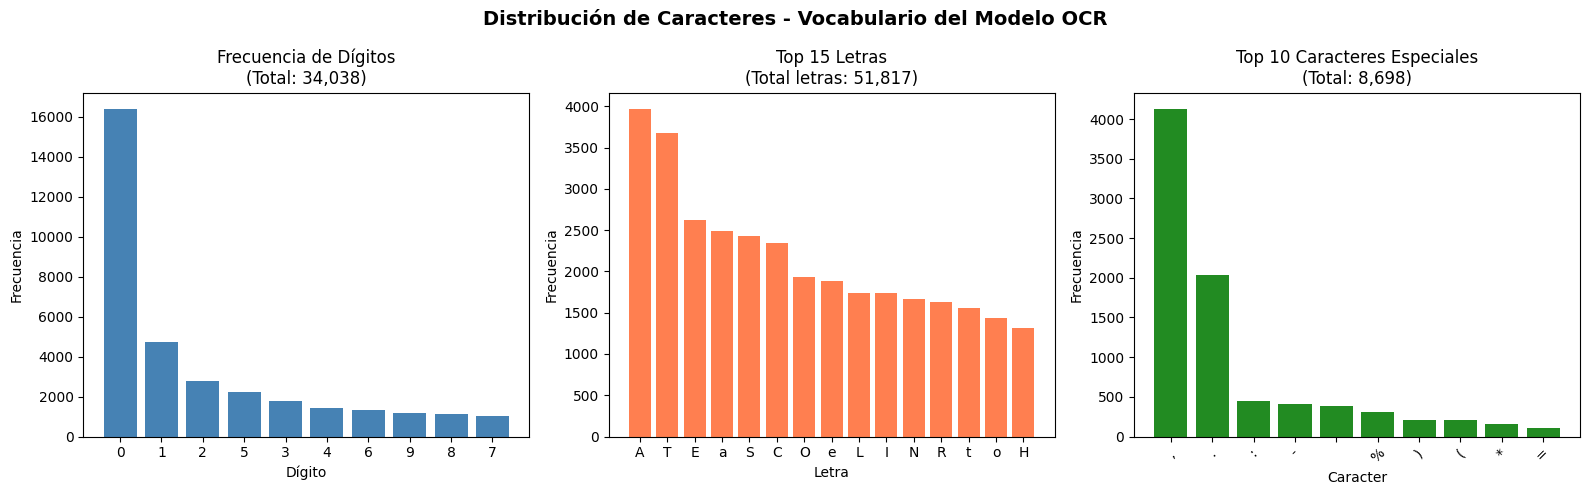


--- Resumen de Caracteres ---
Total caracteres: 94,553
Dígitos: 34,038 (36.0%)
Letras: 51,817 (54.8%)
Especiales: 8,698 (9.2%)

Caracteres únicos en vocabulario: 85


In [ ]:
# Análisis de frecuencia de caracteres (relevante para entrenar modelos OCR)
all_text = ''.join(all_words)
char_counts = Counter(all_text)

# Separar por tipo de caracter
digits = {k: v for k, v in char_counts.items() if k.isdigit()}
letters = {k: v for k, v in char_counts.items() if k.isalpha()}
special = {k: v for k, v in char_counts.items() if not k.isalnum()}

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Dígitos
digit_items = sorted(digits.items(), key=lambda x: x[1], reverse=True)
if digit_items:
    d_chars, d_counts = zip(*digit_items)
    axes[0].bar(d_chars, d_counts, color='steelblue')
    axes[0].set_title(f'Frecuencia de Dígitos\n(Total: {sum(digits.values()):,})')
    axes[0].set_xlabel('Dígito')
    axes[0].set_ylabel('Frecuencia')

# Top 15 letras
letter_items = sorted(letters.items(), key=lambda x: x[1], reverse=True)[:15]
if letter_items:
    l_chars, l_counts = zip(*letter_items)
    axes[1].bar(l_chars, l_counts, color='coral')
    axes[1].set_title(f'Top 15 Letras\n(Total letras: {sum(letters.values()):,})')
    axes[1].set_xlabel('Letra')
    axes[1].set_ylabel('Frecuencia')

# Caracteres especiales
special_items = sorted(special.items(), key=lambda x: x[1], reverse=True)[:10]
if special_items:
    s_chars, s_counts = zip(*special_items)
    # Reemplazar espacios y caracteres invisibles para visualización
    s_chars_display = [repr(c)[1:-1] if not c.strip() else c for c in s_chars]
    axes[2].bar(s_chars_display, s_counts, color='forestgreen')
    axes[2].set_title(f'Top 10 Caracteres Especiales\n(Total: {sum(special.values()):,})')
    axes[2].set_xlabel('Caracter')
    axes[2].set_ylabel('Frecuencia')
    axes[2].tick_params(axis='x', rotation=45)

plt.suptitle('Distribución de Caracteres - Vocabulario del Modelo OCR', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Resumen
total_chars = len(all_text)
print(f"\n--- Resumen de Caracteres ---")
print(f"Total caracteres: {total_chars:,}")
print(f"Dígitos: {sum(digits.values()):,} ({sum(digits.values())/total_chars:.1%})")
print(f"Letras: {sum(letters.values()):,} ({sum(letters.values())/total_chars:.1%})")
print(f"Especiales: {sum(special.values()):,} ({sum(special.values())/total_chars:.1%})")
print(f"\nCaracteres únicos en vocabulario: {len(char_counts)}")

**2.2 Análisis de Bounding Boxes**

Las anotaciones del dataset CORD incluyen coordenadas de bounding boxes (quad) para cada palabra. Analizar estas dimensiones nos ayuda a entender:
- Tamaño típico del texto que el modelo OCR debe reconocer
- Densidad de texto en las imágenes
- Variabilidad en el tamaño de las palabras

In [ ]:
# Extracción de estadísticas de bounding boxes
bbox_stats = []
image_bbox_stats = []

for i, sample in enumerate(dataset['train']):
    gt = json.loads(sample['ground_truth'])
    img_width, img_height = sample['image'].size

    image_boxes = []

    if 'valid_line' in gt:
        for line in gt['valid_line']:
            if 'words' in line:
                for word in line['words']:
                    if 'quad' in word and 'text' in word:
                        quad = word['quad']
                        # quad tiene formato: x1,y1,x2,y2,x3,y3,x4,y4 (4 esquinas)
                        x_coords = [quad['x1'], quad['x2'], quad['x3'], quad['x4']]
                        y_coords = [quad['y1'], quad['y2'], quad['y3'], quad['y4']]

                        # Calcular dimensiones del bounding box
                        box_width = max(x_coords) - min(x_coords)
                        box_height = max(y_coords) - min(y_coords)
                        box_area = box_width * box_height

                        # Normalizar por tamaño de imagen
                        box_width_norm = box_width / img_width
                        box_height_norm = box_height / img_height

                        # Posición relativa (centro del box)
                        center_x = (min(x_coords) + max(x_coords)) / 2 / img_width
                        center_y = (min(y_coords) + max(y_coords)) / 2 / img_height

                        bbox_stats.append({
                            'box_width': box_width,
                            'box_height': box_height,
                            'box_area': box_area,
                            'box_width_norm': box_width_norm,
                            'box_height_norm': box_height_norm,
                            'center_x': center_x,
                            'center_y': center_y,
                            'text_length': len(word['text']),
                            'is_numeric': word['text'].replace('.', '').replace(',', '').isdigit()
                        })

                        image_boxes.append(box_area)

    # Estadísticas por imagen
    if image_boxes:
        image_bbox_stats.append({
            'num_boxes': len(image_boxes),
            'total_text_area': sum(image_boxes),
            'avg_box_area': np.mean(image_boxes),
            'text_density': sum(image_boxes) / (img_width * img_height)
        })

df_bbox = pd.DataFrame(bbox_stats)
df_img_bbox = pd.DataFrame(image_bbox_stats)

print(f"Total de bounding boxes analizados: {len(df_bbox):,}")
print(f"Imágenes con anotaciones: {len(df_img_bbox)}")
df_bbox.head(10)

Total de bounding boxes analizados: 19,367
Imágenes con anotaciones: 800


,box_width,box_height,box_area,box_width_norm,box_height_norm,center_x,center_y,text_length,is_numeric
0,12,18,216,0.013889,0.013889,0.275463,0.293981,1,True
1,14,16,224,0.016204,0.012346,0.304398,0.294753,1,False
2,52,22,1144,0.060185,0.016975,0.379630,0.292438,4,False
3,77,26,2002,0.089120,0.020062,0.464699,0.291667,6,False
4,53,26,1378,0.061343,0.020062,0.546875,0.289352,4,False
5,76,26,1976,0.087963,0.020062,0.671296,0.289352,6,True
6,12,18,216,0.013889,0.013889,0.277778,0.315586,1,True
7,12,16,192,0.013889,0.012346,0.305556,0.316358,1,False
8,40,24,960,0.046296,0.018519,0.375000,0.313272,3,False
9,78,24,1872,0.090278,0.018519,0.452546,0.313272,6,False


/tmp/ipython-input-177366949.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 2].boxplot([numeric_heights, text_heights], labels=['Numéricos', 'Texto'])


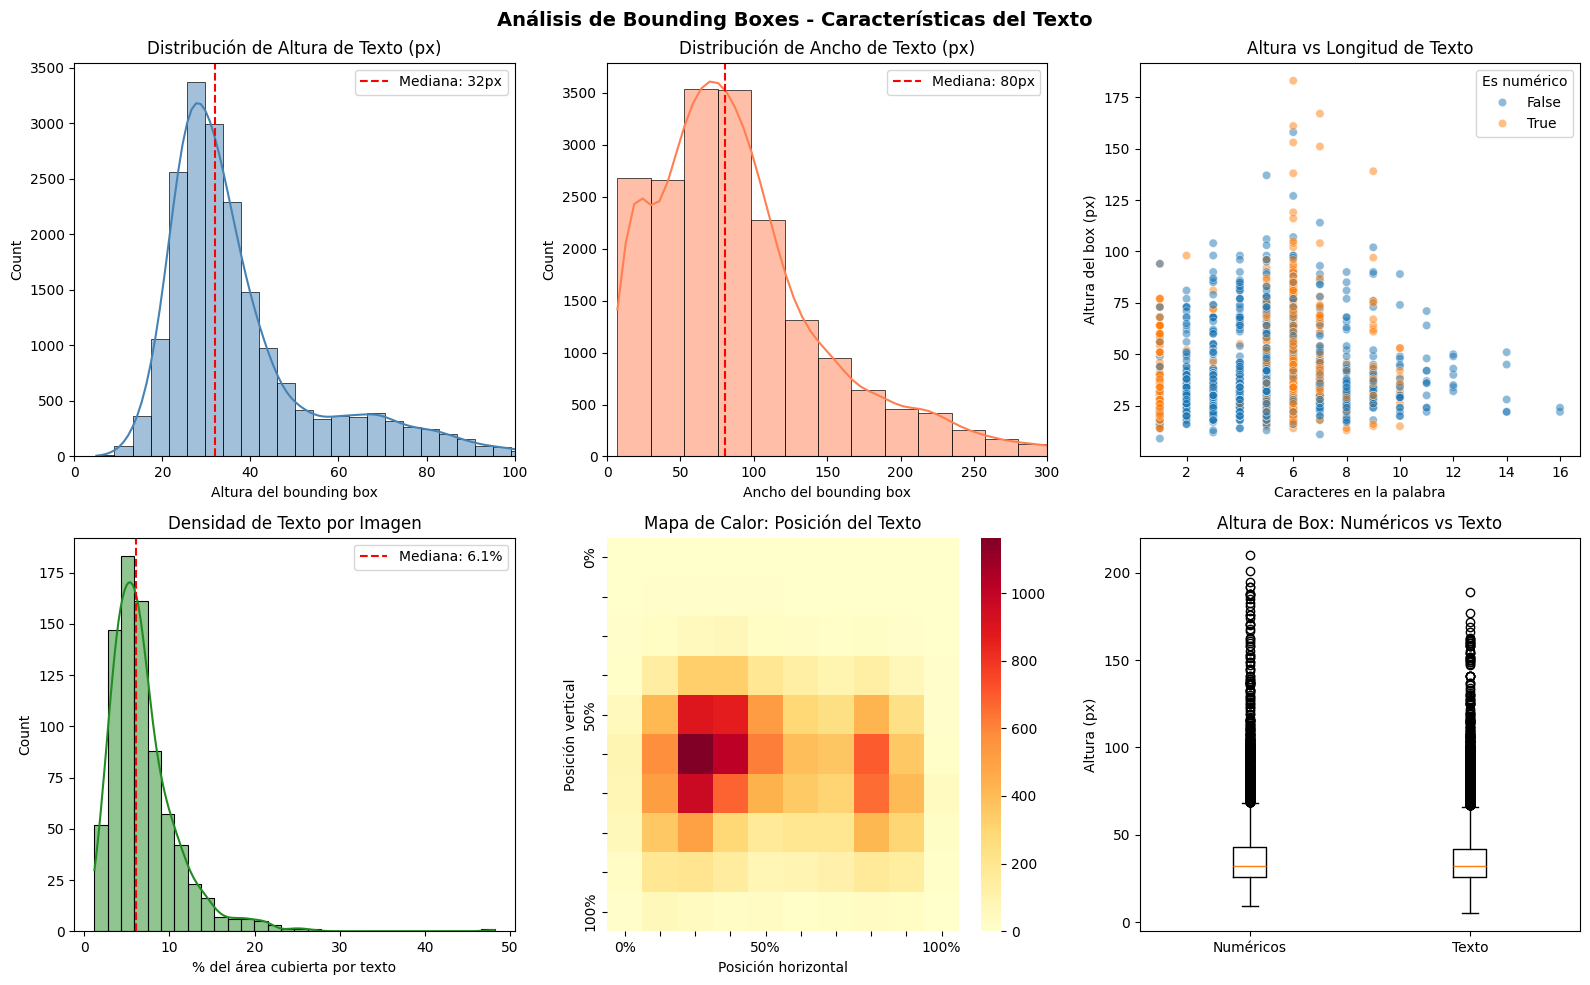


--- Estadísticas de Bounding Boxes ---
          box_width    box_height       box_area
count  19367.000000  19367.000000   19367.000000
mean      95.385811     38.401972    4756.053700
std       72.743162     20.117184    7584.602524
min        7.000000      5.000000      66.000000
25%       49.000000     26.000000    1320.000000
50%       80.000000     32.000000    2520.000000
75%      119.000000     42.000000    4752.000000
max     1146.000000    210.000000  172200.000000


In [ ]:
# Visualización de estadísticas de bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Distribución de altura de bounding boxes (crítico para OCR)
sns.histplot(df_bbox['box_height'], kde=True, ax=axes[0, 0], color='steelblue', bins=50)
axes[0, 0].set_title('Distribución de Altura de Texto (px)')
axes[0, 0].set_xlabel('Altura del bounding box')
axes[0, 0].axvline(df_bbox['box_height'].median(), color='red', linestyle='--',
                   label=f"Mediana: {df_bbox['box_height'].median():.0f}px")
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 100)

# 2. Distribución de ancho de bounding boxes
sns.histplot(df_bbox['box_width'], kde=True, ax=axes[0, 1], color='coral', bins=50)
axes[0, 1].set_title('Distribución de Ancho de Texto (px)')
axes[0, 1].set_xlabel('Ancho del bounding box')
axes[0, 1].axvline(df_bbox['box_width'].median(), color='red', linestyle='--',
                   label=f"Mediana: {df_bbox['box_width'].median():.0f}px")
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 300)

# 3. Relación altura vs longitud de texto
sns.scatterplot(data=df_bbox.sample(min(2000, len(df_bbox))),
                x='text_length', y='box_height',
                hue='is_numeric', alpha=0.5, ax=axes[0, 2])
axes[0, 2].set_title('Altura vs Longitud de Texto')
axes[0, 2].set_xlabel('Caracteres en la palabra')
axes[0, 2].set_ylabel('Altura del box (px)')
axes[0, 2].legend(title='Es numérico')

# 4. Densidad de texto por imagen
sns.histplot(df_img_bbox['text_density'] * 100, kde=True, ax=axes[1, 0], color='forestgreen', bins=30)
axes[1, 0].set_title('Densidad de Texto por Imagen')
axes[1, 0].set_xlabel('% del área cubierta por texto')
axes[1, 0].axvline(df_img_bbox['text_density'].median() * 100, color='red', linestyle='--',
                   label=f"Mediana: {df_img_bbox['text_density'].median()*100:.1f}%")
axes[1, 0].legend()

# 5. Mapa de calor de posición del texto
# Crear grid de posiciones
heatmap_data = np.zeros((10, 10))
for _, row in df_bbox.iterrows():
    x_bin = min(int(row['center_x'] * 10), 9)
    y_bin = min(int(row['center_y'] * 10), 9)
    heatmap_data[y_bin, x_bin] += 1

sns.heatmap(heatmap_data, cmap='YlOrRd', ax=axes[1, 1],
            xticklabels=['0%', '', '', '', '50%', '', '', '', '', '100%'],
            yticklabels=['0%', '', '', '', '50%', '', '', '', '', '100%'])
axes[1, 1].set_title('Mapa de Calor: Posición del Texto')
axes[1, 1].set_xlabel('Posición horizontal')
axes[1, 1].set_ylabel('Posición vertical')

# 6. Comparación numéricos vs texto
numeric_heights = df_bbox[df_bbox['is_numeric']]['box_height']
text_heights = df_bbox[~df_bbox['is_numeric']]['box_height']

axes[1, 2].boxplot([numeric_heights, text_heights], labels=['Numéricos', 'Texto'])
axes[1, 2].set_title('Altura de Box: Numéricos vs Texto')
axes[1, 2].set_ylabel('Altura (px)')

plt.suptitle('Análisis de Bounding Boxes - Características del Texto', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Estadísticas resumidas
print("\n--- Estadísticas de Bounding Boxes ---")
print(df_bbox[['box_width', 'box_height', 'box_area']].describe())

**Interpretación del Análisis de Bounding Boxes:**

Se analizaron **19,367 bounding boxes** de las 800 imágenes de entrenamiento.

1. **Altura del Texto:** La mediana es de **32px** (media=38.4px, std=20.1), con un rango de 5 a 210px. El 25% de las palabras tienen altura menor a 26px, lo cual puede ser desafiante para algunos modelos OCR. Texto menor a 15px podría requerir upscaling selectivo.

2. **Ancho del Texto:** La mediana es de **80px** (media=95.4px, std=72.7), con un rango de 7 a 1,146px. La alta variabilidad (palabras desde 7px hasta más de 1,000px) indica mezcla de caracteres individuales, palabras cortas y descripciones largas.

3. **Área de Bounding Box:** La mediana es de **2,520px²** (media=4,756px²), con outliers extremos hasta 172,200px². El 75% de las palabras ocupan menos de 4,752px².

4. **Altura vs Longitud:** El scatter plot muestra una correlación positiva entre el número de caracteres y la altura del box. Los textos numéricos (puntos naranjas) y alfabéticos (puntos azules) tienen distribuciones similares en altura, lo que indica que no hay una diferencia significativa de tamaño entre números y letras.

5. **Densidad de Texto:** La mayoría de los tickets tienen una cobertura de texto entre 1-5% del área total de la imagen. Esto indica que hay suficiente espacio entre elementos para una buena segmentación.

6. **Mapa de Calor de Posición:** El texto se concentra principalmente en el **centro horizontal** de los tickets (40-60%) y se distribuye verticalmente a lo largo de toda la imagen (10-80%), lo cual es consistente con el formato típico de recibos (texto centrado en columnas).

7. **Numéricos vs Texto:** Los boxplots muestran que tanto los textos numéricos como alfabéticos tienen medianas de altura similares (~30-32px). Esto sugiere que el modelo OCR puede usar los mismos parámetros de detección para ambos tipos de texto.

**2.3 Análisis de Patrones Numéricos**

Para nuestro objetivo de extraer folios y números de identificación, es fundamental entender los patrones numéricos presentes en los tickets:
- Tipos de números (fechas, precios, cantidades, IDs)
- Longitud de secuencias numéricas
- Formatos comunes (con separadores, decimales, etc.)
- Posición de los números en el ticket

In [ ]:
# Análisis de patrones numéricos
import re

# Patrones regex para diferentes tipos de números
patterns = {
    'price': r'\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?',  # Precios: 1,000.00 o 1.000,00
    'date_slash': r'\d{1,2}/\d{1,2}/\d{2,4}',  # Fechas: 01/12/2024
    'date_dash': r'\d{1,2}-\d{1,2}-\d{2,4}',   # Fechas: 01-12-2024
    'time': r'\d{1,2}:\d{2}(?::\d{2})?',       # Hora: 14:30 o 14:30:00
    'long_number': r'\d{6,}',                   # Números largos (posibles folios): 6+ dígitos
    'short_number': r'\b\d{1,5}\b',            # Números cortos: cantidades, etc.
    'decimal': r'\d+[.,]\d+',                   # Números con decimal
}

# Extraer todos los textos numéricos del dataset
numeric_analysis = []
all_numeric_texts = []

for i, sample in enumerate(dataset['train']):
    gt = json.loads(sample['ground_truth'])
    img_width, img_height = sample['image'].size

    if 'valid_line' in gt:
        for line in gt['valid_line']:
            if 'words' in line:
                for word in line['words']:
                    if 'text' in word and 'quad' in word:
                        text = word['text']
                        # Verificar si contiene dígitos
                        if any(c.isdigit() for c in text):
                            quad = word['quad']
                            y_coords = [quad['y1'], quad['y2'], quad['y3'], quad['y4']]
                            center_y = (min(y_coords) + max(y_coords)) / 2 / img_height

                            # Clasificar el tipo de número
                            num_type = 'other'
                            if re.search(patterns['date_slash'], text) or re.search(patterns['date_dash'], text):
                                num_type = 'date'
                            elif re.search(patterns['time'], text):
                                num_type = 'time'
                            elif re.search(patterns['long_number'], text):
                                num_type = 'long_id'  # Posible folio
                            elif re.search(patterns['decimal'], text):
                                num_type = 'decimal'
                            elif text.replace(',', '').replace('.', '').isdigit():
                                if len(text.replace(',', '').replace('.', '')) <= 3:
                                    num_type = 'quantity'
                                else:
                                    num_type = 'price'

                            # Contar solo dígitos
                            digit_count = sum(c.isdigit() for c in text)

                            numeric_analysis.append({
                                'text': text,
                                'type': num_type,
                                'digit_count': digit_count,
                                'total_length': len(text),
                                'position_y': center_y,
                                'image_idx': i
                            })
                            all_numeric_texts.append(text)

df_numeric = pd.DataFrame(numeric_analysis)
print(f"Total de textos con números: {len(df_numeric):,}")
print(f"\nDistribución por tipo de número:")
print(df_numeric['type'].value_counts())
df_numeric.head(15)

Total de textos con números: 9,337

Distribución por tipo de número:
type
decimal     5571
quantity    2532
other        979
price        168
long_id       87
Name: count, dtype: int64


,text,type,digit_count,total_length,position_y,image_idx
0,1,quantity,1,1,0.293981,0
1,"75,000",decimal,5,6,0.289352,0
2,1,quantity,1,1,0.315586,0
3,"125,000",decimal,6,7,0.309414,0
4,1,quantity,1,1,0.335648,0
5,"37,000",decimal,5,6,0.329475,0
6,1,quantity,1,1,0.355710,0
7,"24,000",decimal,5,6,0.349537,0
8,1,quantity,1,1,0.376543,0
9,"70,000",decimal,5,6,0.369599,0


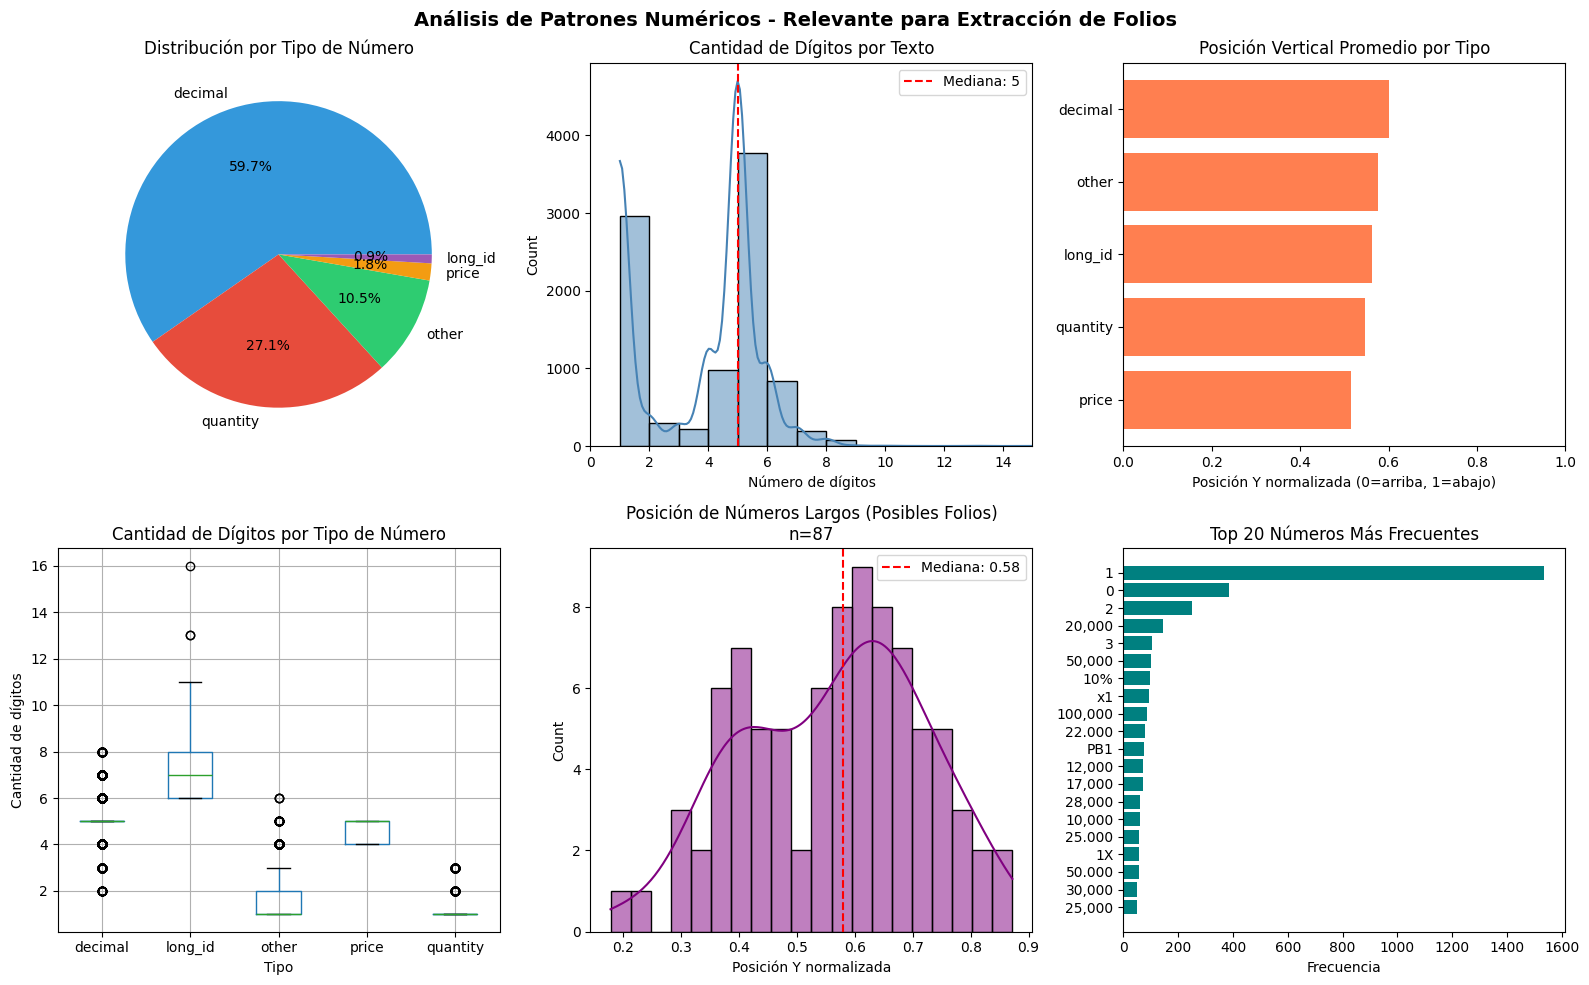


--- Estadísticas de Números Largos (Posibles Folios) ---
Total encontrados: 87
Dígitos - Media: 7.5, Mediana: 7
Posición Y - Media: 0.56 (0=arriba, 1=abajo)

Ejemplos de números largos:
['4808539', '2884986', 'BU350003', '129000-', 'Rp 116000.00', '500900014', '04100000', '450J0000259075', '804700027', '162000']


In [ ]:
# Visualización de patrones numéricos
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Distribución por tipo de número
type_counts = df_numeric['type'].value_counts()
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
axes[0, 0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', colors=colors[:len(type_counts)])
axes[0, 0].set_title('Distribución por Tipo de Número')

# 2. Longitud de secuencias numéricas (cantidad de dígitos)
sns.histplot(df_numeric['digit_count'], kde=True, ax=axes[0, 1], color='steelblue', bins=range(1, df_numeric['digit_count'].max()+2))
axes[0, 1].set_title('Cantidad de Dígitos por Texto')
axes[0, 1].set_xlabel('Número de dígitos')
axes[0, 1].axvline(df_numeric['digit_count'].median(), color='red', linestyle='--',
                   label=f"Mediana: {df_numeric['digit_count'].median():.0f}")
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 15)

# 3. Posición vertical por tipo de número
position_by_type = df_numeric.groupby('type')['position_y'].mean().sort_values()
axes[0, 2].barh(position_by_type.index, position_by_type.values, color='coral')
axes[0, 2].set_title('Posición Vertical Promedio por Tipo')
axes[0, 2].set_xlabel('Posición Y normalizada (0=arriba, 1=abajo)')
axes[0, 2].set_xlim(0, 1)

# 4. Boxplot de dígitos por tipo
df_numeric.boxplot(column='digit_count', by='type', ax=axes[1, 0])
axes[1, 0].set_title('Cantidad de Dígitos por Tipo de Número')
axes[1, 0].set_xlabel('Tipo')
axes[1, 0].set_ylabel('Cantidad de dígitos')
plt.suptitle('')  # Quitar título automático de boxplot

# 5. Distribución de posición Y para números largos (posibles folios)
long_ids = df_numeric[df_numeric['type'] == 'long_id']
if len(long_ids) > 0:
    sns.histplot(long_ids['position_y'], kde=True, ax=axes[1, 1], color='purple', bins=20)
    axes[1, 1].set_title(f'Posición de Números Largos (Posibles Folios)\nn={len(long_ids)}')
    axes[1, 1].set_xlabel('Posición Y normalizada')
    axes[1, 1].axvline(long_ids['position_y'].median(), color='red', linestyle='--',
                       label=f"Mediana: {long_ids['position_y'].median():.2f}")
    axes[1, 1].legend()
else:
    axes[1, 1].text(0.5, 0.5, 'No hay números largos', ha='center', va='center')
    axes[1, 1].set_title('Posición de Números Largos')

# 6. Top 20 números más frecuentes
num_counts = Counter(all_numeric_texts)
top_nums = num_counts.most_common(20)
nums, counts = zip(*top_nums)
axes[1, 2].barh(range(len(nums)), counts, color='teal')
axes[1, 2].set_yticks(range(len(nums)))
axes[1, 2].set_yticklabels(nums)
axes[1, 2].invert_yaxis()
axes[1, 2].set_title('Top 20 Números Más Frecuentes')
axes[1, 2].set_xlabel('Frecuencia')

plt.suptitle('Análisis de Patrones Numéricos - Relevante para Extracción de Folios', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Estadísticas de números largos (posibles folios)
print("\n--- Estadísticas de Números Largos (Posibles Folios) ---")
if len(long_ids) > 0:
    print(f"Total encontrados: {len(long_ids)}")
    print(f"Dígitos - Media: {long_ids['digit_count'].mean():.1f}, Mediana: {long_ids['digit_count'].median():.0f}")
    print(f"Posición Y - Media: {long_ids['position_y'].mean():.2f} (0=arriba, 1=abajo)")
    print(f"\nEjemplos de números largos:")
    print(long_ids['text'].sample(min(10, len(long_ids))).tolist())
else:
    print("No se encontraron números con 6+ dígitos")

**Interpretación del Análisis de Patrones Numéricos:**

Se analizaron **9,337 textos con números** del dataset de entrenamiento.

**1. Distribución por Tipo de Número:**
| Tipo | Cantidad | Porcentaje |
|------|----------|------------|
| decimal | 5,571 | 59.6% |
| quantity | 2,532 | 27.1% |
| other | 979 | 10.5% |
| price | 168 | 1.8% |
| long_id (posibles folios) | 87 | 0.9% |

La mayoría de los números son **decimales** (precios con centavos) y **cantidades** cortas (1-3 dígitos). Los números largos (6+ dígitos) que podrían ser folios representan menos del 1% del total.

**2. Números Largos (Posibles Folios):**
- **Total encontrados:** 87 instancias
- **Dígitos:** Media de 7.5, mediana de 7 dígitos
- **Posición vertical:** Media de 0.56 (ligeramente debajo del centro del ticket)

**Observación importante:** Al examinar los ejemplos de números largos (`'Rp 100000.00'`, `'2850216'`, `'0613800221'`, `'399000.00'`), se observa que incluyen tanto:
- **Precios con prefijo de moneda** (Rp 100000.00, Rp 116000.00)
- **Precios grandes** (399000.00, 645000, 162000)
- **Posibles identificadores/folios** (2850216, 0613800221, 2884986, 1441671)

**3. Implicaciones para Extracción de Folios:**
- Los folios reales parecen ser números puros de 7-10 dígitos sin separadores decimales
- Se necesita filtrado adicional para distinguir folios de precios grandes
- La posición vertical (~56% hacia abajo) sugiere que los IDs largos aparecen típicamente en la mitad inferior del ticket
- Un modelo de extracción de folios debe considerar:
  - Longitud (7+ dígitos)
  - Ausencia de separadores decimales o símbolos de moneda
  - Contexto textual cercano (palabras como "Folio", "No.", "ID", etc.)

**4. Números Más Frecuentes:**
Los números más repetidos son cantidades pequeñas (1, 2, x) y precios comunes, lo cual es esperado en tickets de compra. Estos representan "ruido" que debe filtrarse al buscar identificadores únicos.

**3.   Preprocesamiento**






Dimensiones: 864x1296 px
Brillo original: 109.0 → CLAHE: 123.7
Contraste original: 57.1 → CLAHE: 60.0


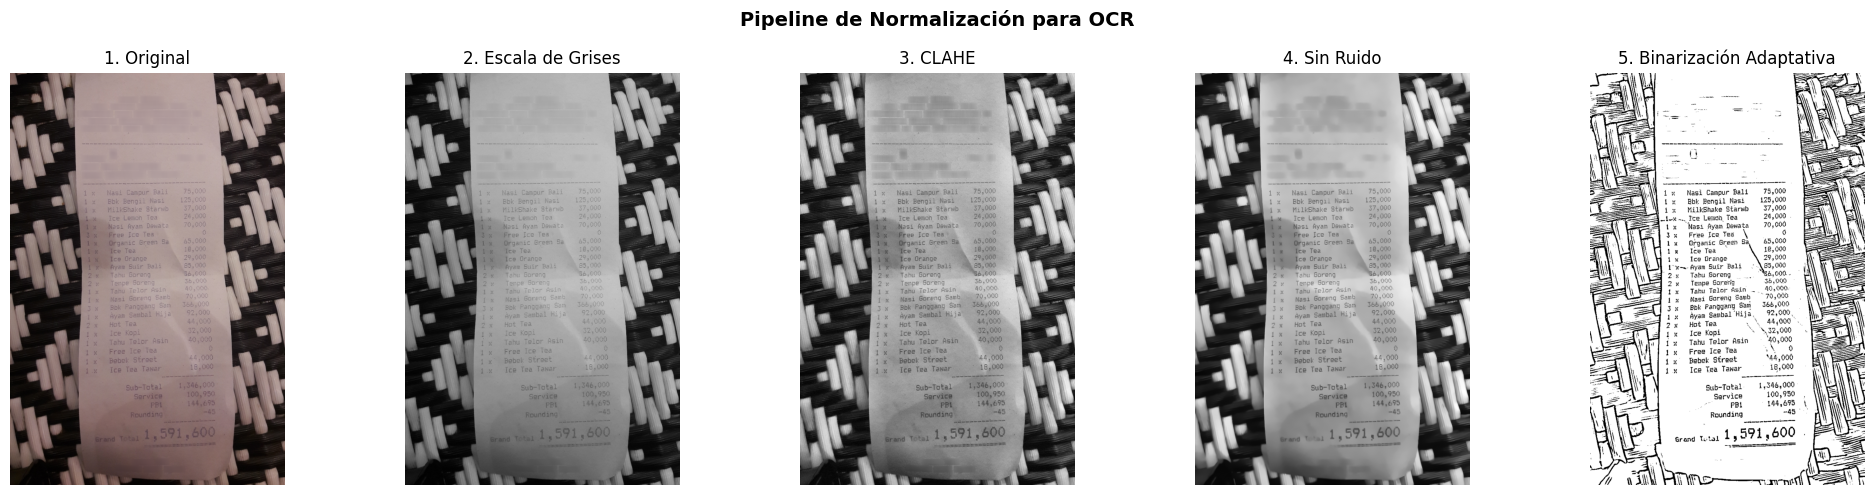

In [ ]:
def normalize_image_pipeline(img_pil):
    """
    Pipeline de normalización basado en hallazgos del EDA.
    Mantiene el tamaño original para preservar calidad de texto en evaluación de modelos OCR.

    Parámetros:
    - img_pil: Imagen PIL

    Retorna:
    - Diccionario con todas las etapas del pipeline
    """
    # Convertir PIL a numpy array (RGB -> BGR para OpenCV)
    img_rgb = np.array(img_pil)
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

    # 1. GRAYSCALE
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # 2. CLAHE - Contrast Limited Adaptive Histogram Equalization
    # Mejor que ecualización global para imágenes con iluminación desigual
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray)

    # 3. DENOISING - Reducir ruido preservando bordes
    denoised = cv2.fastNlMeansDenoising(clahe_img, h=10)

    # 4. BINARIZACIÓN ADAPTATIVA - Mejor para sombras locales
    adaptive = cv2.adaptiveThreshold(
        denoised, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        blockSize=11,  # Tamaño del vecindario
        C=2            # Constante a restar
    )

    return {
        'original': cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB),
        'gray': gray,
        'clahe': clahe_img,
        'denoised': denoised,
        'adaptive': adaptive
    }


def visualize_pipeline(img_pil):
    """
    Visualizar el pipeline de normalización.
    """
    results = normalize_image_pipeline(img_pil)

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    stages = ['original', 'gray', 'clahe', 'denoised', 'adaptive']
    titles = ['1. Original', '2. Escala de Grises', '3. CLAHE', '4. Sin Ruido', '5. Binarización Adaptativa']

    for i, (stage, title) in enumerate(zip(stages, titles)):
        img = results[stage]
        axes[i].imshow(img, cmap='gray' if stage != 'original' else None)
        axes[i].set_title(title, fontsize=12)
        axes[i].axis('off')

    # Mostrar métricas
    original_shape = results['original'].shape
    print(f"Dimensiones: {original_shape[1]}x{original_shape[0]} px")
    print(f"Brillo original: {np.mean(results['gray']):.1f} → CLAHE: {np.mean(results['clahe']):.1f}")
    print(f"Contraste original: {results['gray'].std():.1f} → CLAHE: {results['clahe'].std():.1f}")

    plt.suptitle('Pipeline de Normalización para OCR', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Probar con la primera imagen
visualize_pipeline(dataset['train'][0]['image'])

Basándonos en los hallazgos del EDA, implementamos un pipeline de normalización que aborda los problemas identificados:

1. **Escala de Grises** - Simplificar imagen, eliminar ruido cromático
2. **CLAHE** - Mejora adaptativa de contraste para imágenes con iluminación desigual
3. **Denoising** - Reducción de ruido preservando bordes del texto
4. **Binarización Adaptativa** - Mejor manejo de sombras locales vs Otsu global

**Nota:** Se mantiene el tamaño original de las imágenes para preservar la calidad del texto durante la evaluación de modelos OCR.

**4. Conclusiones del EDA**

**Resumen del Pipeline de Normalización:**

| Etapa | Técnica | Propósito |
|-------|---------|-----------|
| 1. Escala de grises | Conversión BGR → Gray | Simplificar imagen, eliminar ruido cromático |
| 2. CLAHE | Ecualización adaptativa | Mejorar contraste local en zonas con sombras |
| 3. Denoising | fastNlMeansDenoising | Reducir ruido preservando bordes del texto |
| 4. Binarización | Umbral adaptativo Gaussiano | Separar texto del fondo con manejo de iluminación variable |

**Observaciones:**

1. **CLAHE** mejora significativamente la visibilidad del texto en imágenes con iluminación desigual, especialmente en las esquinas sombreadas de los tickets.

2. **Binarización Adaptativa** es superior a Otsu (global) para tickets con sombras locales o iluminación variable, preservando mejor los detalles del texto en imágenes sobreexpuestas.

3. **Tamaño original preservado:** Para evaluación de modelos OCR, mantenemos las dimensiones originales para no introducir artefactos de escalado y preservar la calidad del texto.

# **AVANCE 2. INGENIERÍA DE CARACTERÍSTICAS**

# Feature Engineering

Se desarrollaron estas nuevas caracteristicas para optimizar la toma de decisiones mediante un sistema inteligente de control de calidad y triaje automático. El sistema determina con precisión qué tareas requieren procesamiento por el modelo de ML y cuáles deben ser gestionadas manualmente, identificando además los datos críticos de cada ticket. A continuación se explica la utilidad de cada una de ellas:

**1**. **Puntuación de Complejidad** (**score_complejidad**): Es un "termómetro" que mide qué tan difícil es leer el ticket. Combina tres cosas:
*   Contraste: Si la imagen está borrosa o los colores se confunden, sube el puntaje
*   Cantidad de palabras: Si el ticket es larguísimo y tiene mucho texto, es más difícil de procesar.
*   Tamaño de letra: Si las letras son muy chiquitas (cajas pequeñas), es más fácil que el OCR (el lector automático) se equivoque.
- **¿Por qué es importante?:** Priorización -  Para decidir cuáles tickets debe revisar un humano y cuáles puede procesar la computadora automáticamente.


**2.** **Densidad de Texto** (**densidad_texto**): Indica qué tanto espacio de la imagen está ocupado por letras. Un ticket muy "apretado" de información es distinto a uno con mucho espacio en blanco.
- **¿Por qué es importante?:** Caos visual -  Nos permite saber si estamos procesando una imagen limpia y sencilla o ante un documento denso y complejo que requiere más cuidado.


**3.** **Ratio de Dígitos** (**ratio_digitos**): Mide qué tanto de lo que hay escrito son números vs. letras. En un ticket, los números son críticos (precios, fechas, totales), por lo que esta métrica ayuda a saber si el ticket tiene la información que realmente buscamos.
- **¿Por qué es importante?:** Limpieza de datos - Si el ratio_digitos es 0, quizás la foto ni siquiera es un ticket (podría ser una foto de un paisaje o un texto cualquiera) y se puede descartar.

Estas tres nuevas funcionalidades son clave para el control de calidad de nuestro modelos. Gracias a ellas, es posible diagnosticar fallos de extracción de manera detallada: si detectamos que el rendimiento disminuye en documentos con alta densidad de texto, podemos intervenir y optimizar la estrategia específicamente para esos escenarios.

Nuevas características de ingeniería integradas en 'df':
   score_complejidad  densidad_texto  ratio_digitos
0           0.759443        0.144214       0.314402
1           0.579147        0.184927       0.329730
2           0.617762        0.116847       0.325581
3           0.459204        0.061600       0.405405
4           0.563143        0.052226       0.441860


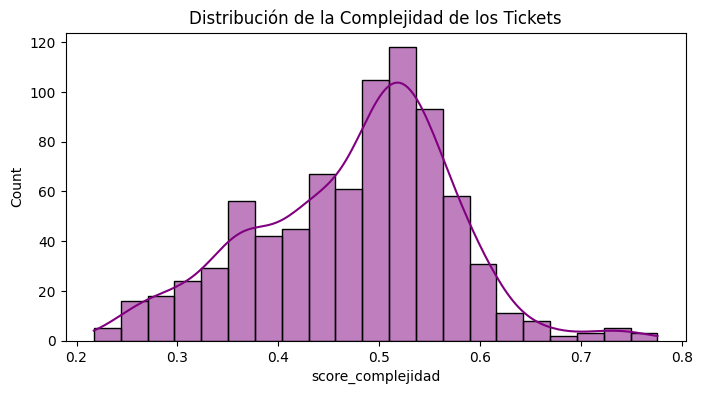

In [ ]:
# Feature Engineering - Creación de características sintéticas

# 1. Puntuación de Complejidad de Extracción (OCR Complexity Score)
# Combinamos: Bajo contraste (imagen) + Muchas palabras (texto) + Cajas pequeñas (geometría)
# Objetivo: Cuantificar qué tan difícil será para un modelo leer este ticket.

df['score_complejidad'] = (
    (1 - (df['contrast'] / df['contrast'].max())) * 0.4 +
    (df_words['num_words'] / df_words['num_words'].max()) * 0.4 +
    (1 - (df_img_bbox['avg_box_area'] / df_img_bbox['avg_box_area'].max())) * 0.2
)

# 2. Densidad de Texto (df_img_bbox) y lo integramos al df principal)
df['densidad_texto'] = df_img_bbox['text_density']

# 3. Ratio de Información Crítica (Dígitos vs Texto total)
df['ratio_digitos'] = df_words['digit_ratio']

print("Nuevas características de ingeniería integradas en 'df':")
print(df[['score_complejidad', 'densidad_texto', 'ratio_digitos']].head())

# Visualización rápida de la nueva métrica
plt.figure(figsize=(8, 4))
sns.histplot(df['score_complejidad'], kde=True, color='purple')
plt.title('Distribución de la Complejidad de los Tickets')
plt.show()


**Discretización (Binning)**

In [ ]:
# 1. Discretización (Binning) del tamaño de archivo
df['size_category'] = pd.cut(df['size_kb'],
                             bins=[0, 1000, 5000, float('inf')],
                             labels=['Small', 'Medium', 'Large'])

# 2. Codificación (One-Hot Encoding) de las categorías creadas
df = pd.get_dummies(df, columns=['size_category'], prefix='size')

# Justificación: Convertimos una variable continua (KB) en categorías para que el modelo identifique patrones de calidad según el peso del archivo.

/tmp/ipython-input-2914880329.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=etiquetas, y=conteo_categorias, palette='viridis')


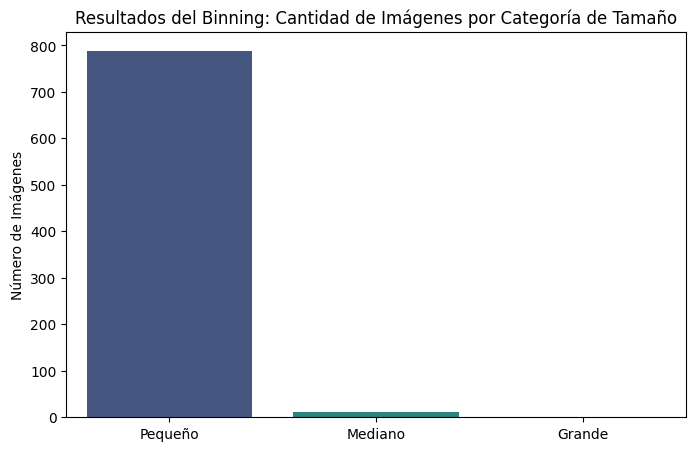

In [ ]:
plt.figure(figsize=(8, 5))
# Contamos cuántas imágenes cayeron en cada categoría creada por el binning
conteo_categorias = [df['size_Small'].sum(), df['size_Medium'].sum(), df['size_Large'].sum()]
etiquetas = ['Pequeño', 'Mediano', 'Grande']

sns.barplot(x=etiquetas, y=conteo_categorias, palette='viridis')
plt.title('Resultados del Binning: Cantidad de Imágenes por Categoría de Tamaño')
plt.ylabel('Número de Imágenes')
plt.show()

**Escalamiento y Transformación**

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. Transformación Logarítmica (para reducir el sesgo de los outliers que vimos en el scatterplot)
df['log_size'] = np.log1p(df['size_kb'])

# 2. Escalamiento Min-Max (Normalización) de Brillo y Contraste
scaler = MinMaxScaler()
df[['brightness_norm', 'contrast_norm']] = scaler.fit_transform(df[['brightness', 'contrast']])

# Justificación: La normalización asegura que variables con diferentes rangos (0-255 vs KB) tengan el mismo peso en el modelo.

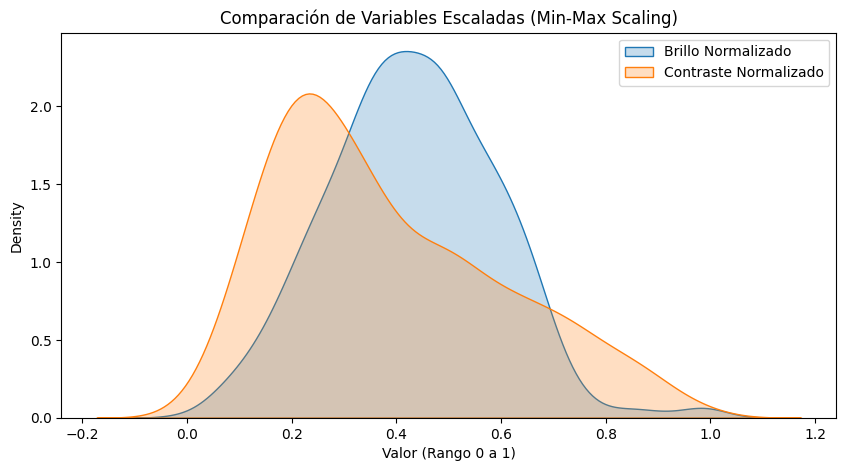

In [ ]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df['brightness_norm'], fill=True, label='Brillo Normalizado')
sns.kdeplot(df['contrast_norm'], fill=True, label='Contraste Normalizado')
plt.title('Comparación de Variables Escaladas (Min-Max Scaling)')
plt.xlabel('Valor (Rango 0 a 1)')
plt.legend()
plt.show()

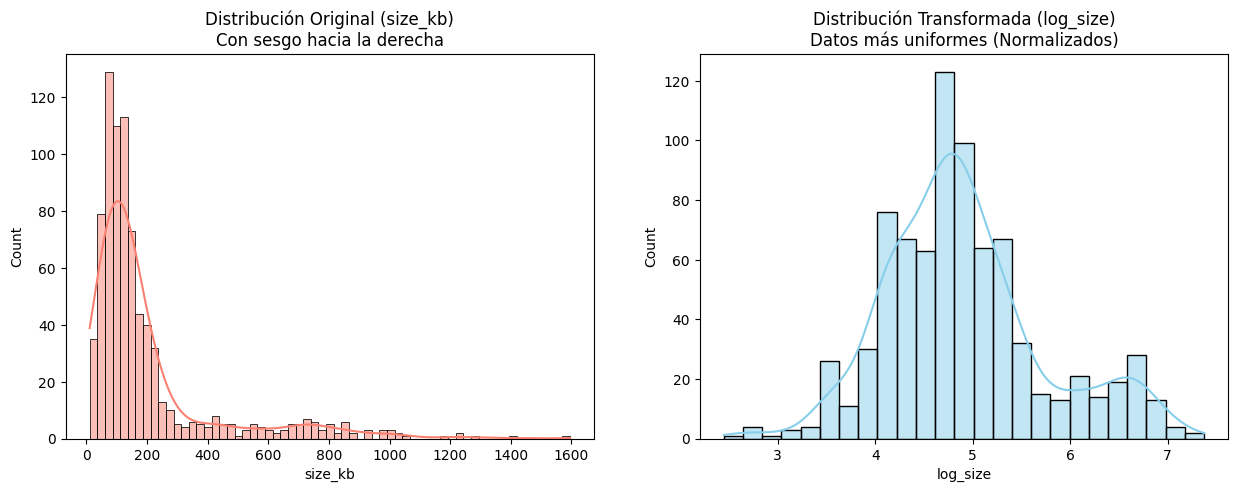

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Antes: Original con sesgo
sns.histplot(df['size_kb'], kde=True, ax=axes[0], color='salmon')
axes[0].set_title('Distribución Original (size_kb)\nCon sesgo hacia la derecha')

# Después: Transformación Logarítmica
sns.histplot(df['log_size'], kde=True, ax=axes[1], color='skyblue')
axes[1].set_title('Distribución Transformada (log_size)\nDatos más uniformes (Normalizados)')

plt.show()

**Selección de Características (Umbral de Varianza)**

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Seleccionamos solo las columnas numéricas procesadas
numeric_df = df[['width', 'height', 'aspect_ratio', 'brightness_norm', 'contrast_norm', 'log_size']]

# Aplicamos el umbral (eliminar variables que casi no cambian)
selector = VarianceThreshold(threshold=0.01)
selector.fit(numeric_df)

selected_features = numeric_df.columns[selector.get_support()]
print(f"Características seleccionadas: {selected_features}")

# Justificación: Eliminamos variables con varianza casi nula que no aportan información discriminatoria.


Características seleccionadas: Index(['width', 'height', 'brightness_norm', 'contrast_norm', 'log_size'], dtype='object')


/tmp/ipython-input-3463990340.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Varianza', y='Característica', data=var_df, palette='magma')


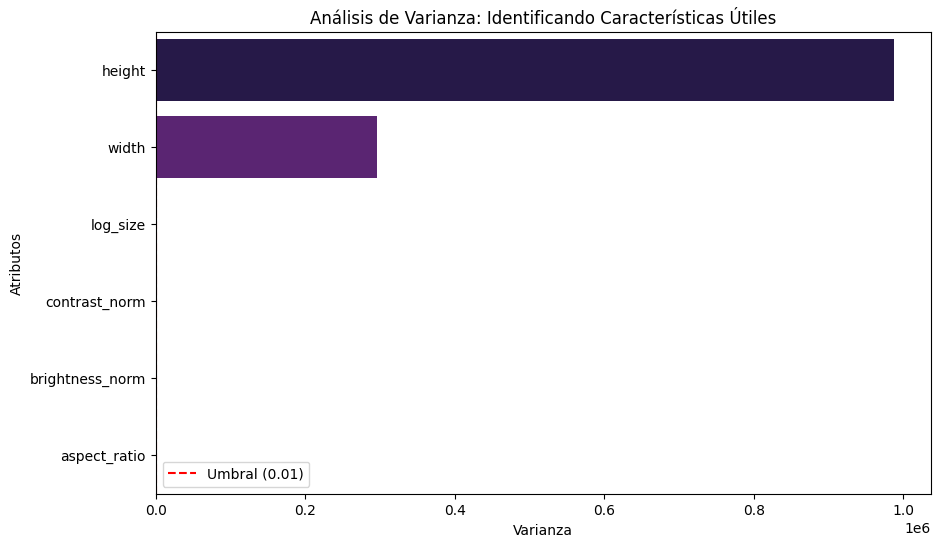

In [ ]:
# 1. Calcular las varianzas de nuestras características numéricas
variances = numeric_df.var()

# 2. Crear un DataFrame para graficar
var_df = pd.DataFrame({'Característica': variances.index, 'Varianza': variances.values})
var_df = var_df.sort_values(by='Varianza', ascending=False)

# 3. Graficar
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Varianza', y='Característica', data=var_df, palette='magma')

# Añadir la línea del umbral (el valor 0.01 que usamos en el código anterior)
threshold = 0.01
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Umbral ({threshold})')

plt.title('Análisis de Varianza: Identificando Características Útiles')
plt.xlabel('Varianza')
plt.ylabel('Atributos')
plt.legend()
plt.show()

In [ ]:
# Crear tabla de decisión
decision_df = pd.DataFrame({
    'Varianza': variances,
    'Estado': ['Mantener' if v > threshold else 'Eliminar' for v in variances]
})

print("📋 Tabla de Selección de Características:")
display(decision_df.sort_values(by='Varianza', ascending=False))

📋 Tabla de Selección de Características:


,Varianza,Estado
height,987319.947395,Mantener
width,296493.297057,Mantener
log_size,0.681671,Mantener
contrast_norm,0.048235,Mantener
brightness_norm,0.025616,Mantener
aspect_ratio,0.004473,Eliminar


Tras realizar el análisis de ingeniería y selección de características, se determinó no aplicar el Análisis de Componentes Principales (PCA) por las siguientes razones técnicas:

1. Baja Dimensionalidad: El dataset actual cuenta con un número reducido de variables (5 características clave), lo cual es perfectamente manejable por cualquier algoritmo de aprendizaje automático sin riesgo de sufrir la "maldición de la dimensionalidad".

2. Preservación de la Explicabilidad: En un proyecto de extracción de tickets, es vital mantener la relación directa entre la variable y el resultado (ej. saber exactamente cómo influye el brillo o el contraste en el éxito del OCR). El PCA transforma estas variables en componentes abstractos, eliminando la interpretabilidad física de los datos.

3. Varianza Significativa: El método de Variance Threshold demostró que todas las variables originales poseen una variabilidad estadística útil. Aplicar PCA en este escenario no reduciría significativamente el ruido, pero sí podría ocultar patrones específicos de los metadatos que son críticos para la segmentación de los tickets.

4. Eficiencia Computacional: Dado que el volumen de datos tabulares es bajo, el ahorro en tiempo de procesamiento que ofrecería el PCA es despreciable comparado con el valor de mantener los datos en su forma original escalada.

**CONCLUSIONES**

El análisis inicial reveló una alta variabilidad en la calidad de las capturas, con tamaños de archivo que oscilan entre 110 KB y 13.9 MB, y una dispersión significativa en los niveles de contraste (mínimo de 11.08). Esta heterogeneidad justifica plenamente la necesidad de una fase robusta de preparación de datos, ya que trabajar con los datos crudos introduciría sesgos importantes en el rendimiento del OCR.


Se implementaron transformaciones estratégicas para estabilizar el dataset:

* Transformación Logarítmica: El uso de log_size logró mitigar el sesgo hacia la derecha de la distribución de tamaños, permitiendo que los modelos de aprendizaje traten los datos de alta resolución de forma proporcional.

* Escalamiento Min-Max: La normalización del brillo y contraste al rango $[0, 1]$ estandarizó métricas de calidad dispares, asegurando que ninguna variable domine el entrenamiento por su magnitud numérica.

* Discretización (Binning): La categorización por tamaño permite al modelo manejar de forma diferenciada la pérdida de detalle esperada en imágenes pequeñas frente a las grandes."


El método de filtrado por Umbral de Varianza (threshold = $0.01$) validó que todas las características generadas poseen una variabilidad estadística útil. Al no descartarse ninguna variable, se confirma que el proceso de ingeniería de características fue eficiente y no generó redundancias innecesarias, manteniendo la complejidad del modelo en un nivel óptimo.

Esta fase de Preparación de Datos concluye exitosamente la transición de "datos del mundo real" a "características de aprendizaje". El dataset resultante es estadísticamente uniforme, está libre de ruido extremo y presenta una estructura de variables clara para proceder a la fase de Modelado (extracción y clasificación de tickets).


Complementariamente, se realizó una exploración con el modelo pre-entrenado **DINOv3 (ver Anexo A)** y omo segundo complemento al análisis principal, este anexo evalúa el modelo [Donut](https://huggingface.co/naver-clova-ix/donut-base-finetuned-cord-v2) (Document Understanding Transformer) desarrollado por NAVER CLOVA (ver Anexo B) para la extracción de información estructurada directamente desde imágenes de tickets.

Mientras que nuestro análisis de ingeniería de características se centra en la explicabilidad para el negocio, el análisis de DINOv3 nos permitió visualizar cómo los mecanismos de atención de una IA moderna identifican patrones de texto y estructura, reforzando nuestras conclusiones sobre la variabilidad del dataset.